In [1]:
print("Dataset Description:")
print("The dataset used is FER-2013, a facial expression recognition dataset containing grayscale images of faces labeled with one of seven emotions. For this task, we exclude 'disgust', using six classes: happy, sad, angry, surprise, fear, neutral. Images are 48x48 pixels.")

Dataset Description:
The dataset used is FER-2013, a facial expression recognition dataset containing grayscale images of faces labeled with one of seven emotions. For this task, we exclude 'disgust', using six classes: happy, sad, angry, surprise, fear, neutral. Images are 48x48 pixels.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import time
from PIL import Image
import warnings

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

base_dir = 'C:/Users/Administrator/OneDrive/Desktop/AI-ML/Coursework-1/facial expression classification'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

**Cleaning the images in the dataset**

In [2]:
from PIL import Image
import os

def clean_corrupted_images(folder_path):
    bad_files = []
    for subdir, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verifies image is readable
            except:
                bad_files.append(file_path)

    print(f"Found {len(bad_files)} corrupted images in {folder_path}")
    for file in bad_files:
        os.remove(file)
    print(f"Removed {len(bad_files)} corrupted images from {folder_path}")

# Clean all datasets
clean_corrupted_images(train_dir)
clean_corrupted_images(val_dir)
clean_corrupted_images(test_dir)

Found 49 corrupted images in C:/Users/Administrator/OneDrive/Desktop/AI-ML/Coursework-1/facial expression classification\train
Removed 49 corrupted images from C:/Users/Administrator/OneDrive/Desktop/AI-ML/Coursework-1/facial expression classification\train
Found 7 corrupted images in C:/Users/Administrator/OneDrive/Desktop/AI-ML/Coursework-1/facial expression classification\validation
Removed 7 corrupted images from C:/Users/Administrator/OneDrive/Desktop/AI-ML/Coursework-1/facial expression classification\validation
Found 0 corrupted images in C:/Users/Administrator/OneDrive/Desktop/AI-ML/Coursework-1/facial expression classification\test
Removed 0 corrupted images from C:/Users/Administrator/OneDrive/Desktop/AI-ML/Coursework-1/facial expression classification\test


# Part A: Implementing CNN from Scratch

Found 26543 images belonging to 6 classes.
Found 6955 images belonging to 6 classes.
Found 1800 images belonging to 6 classes.


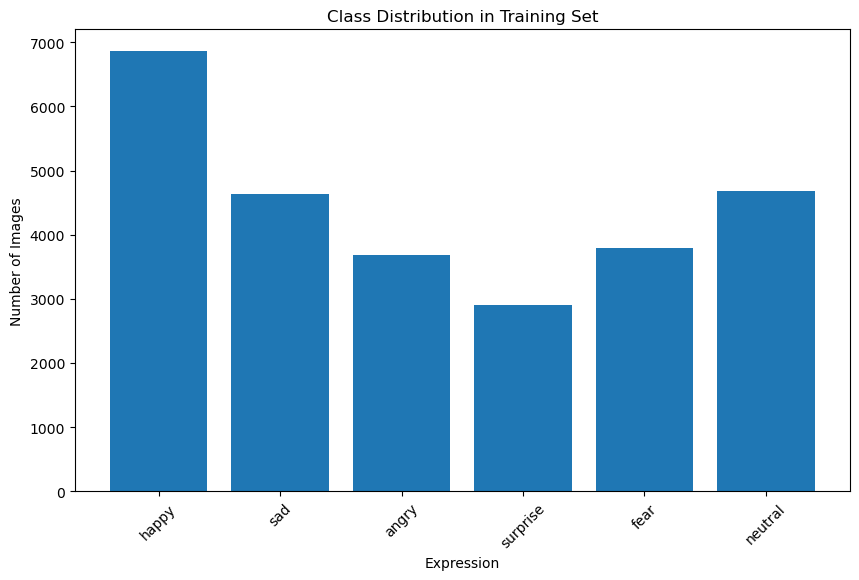

In [6]:
#Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    classes=['happy', 'sad', 'angry', 'surprise', 'fear', 'neutral']  # Excluding Disgust
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    classes=['happy', 'sad', 'angry', 'surprise', 'fear', 'neutral']
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    classes=['happy', 'sad', 'angry', 'surprise', 'fear', 'neutral']
)

# Visualize class distribution
class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name)))
                for class_name in train_generator.class_indices.keys()}
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution in Training Set')
plt.xlabel('Expression')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# 3.1.2 Design, Train, and Evaluate Baseline Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

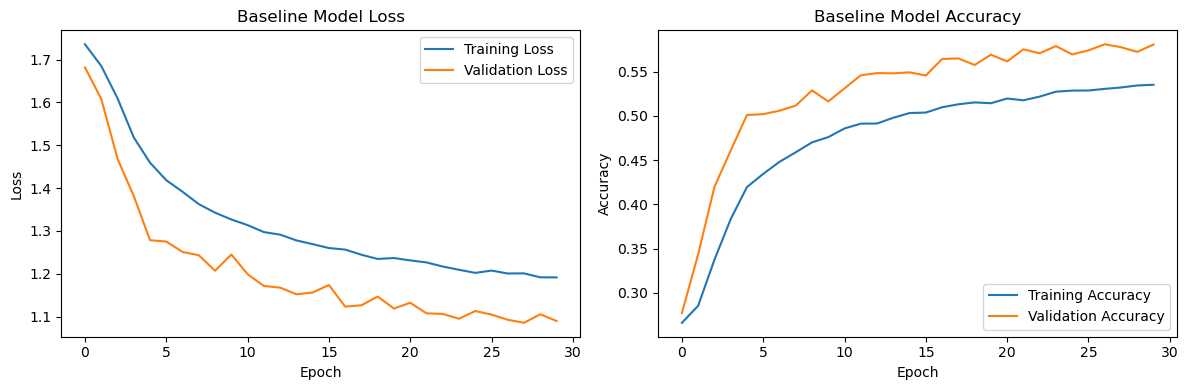

In [4]:
# Baseline CNN Model
baseline_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')  # 6 classes excluding Disgust
])

baseline_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

baseline_model.summary()

# Train baseline model
history_baseline = baseline_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    verbose=1
)

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['accuracy'], label='Training Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

**Evaluate baseline model**

57/57 [==============================] - 25s 437ms/step - loss: 1.2028 - accuracy: 0.5417
Test Accuracy: 0.5417
57/57 [==============================] - 2s 29ms/step

Classification Report:
              precision    recall  f1-score   support

       happy       0.18      0.24      0.20       300
         sad       0.19      0.13      0.15       300
       angry       0.15      0.12      0.13       300
    surprise       0.17      0.16      0.16       300
        fear       0.18      0.13      0.15       300
     neutral       0.17      0.26      0.20       300

    accuracy                           0.17      1800
   macro avg       0.17      0.17      0.17      1800
weighted avg       0.17      0.17      0.17      1800



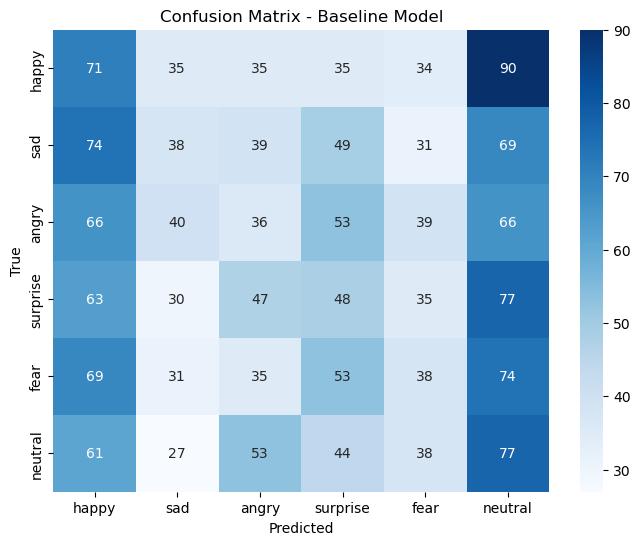

In [5]:
test_loss, test_accuracy = baseline_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions
test_generator.reset()
y_pred = baseline_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Baseline Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Visualize sample predictions**

1/1 [==============================] - 0s 144ms/step


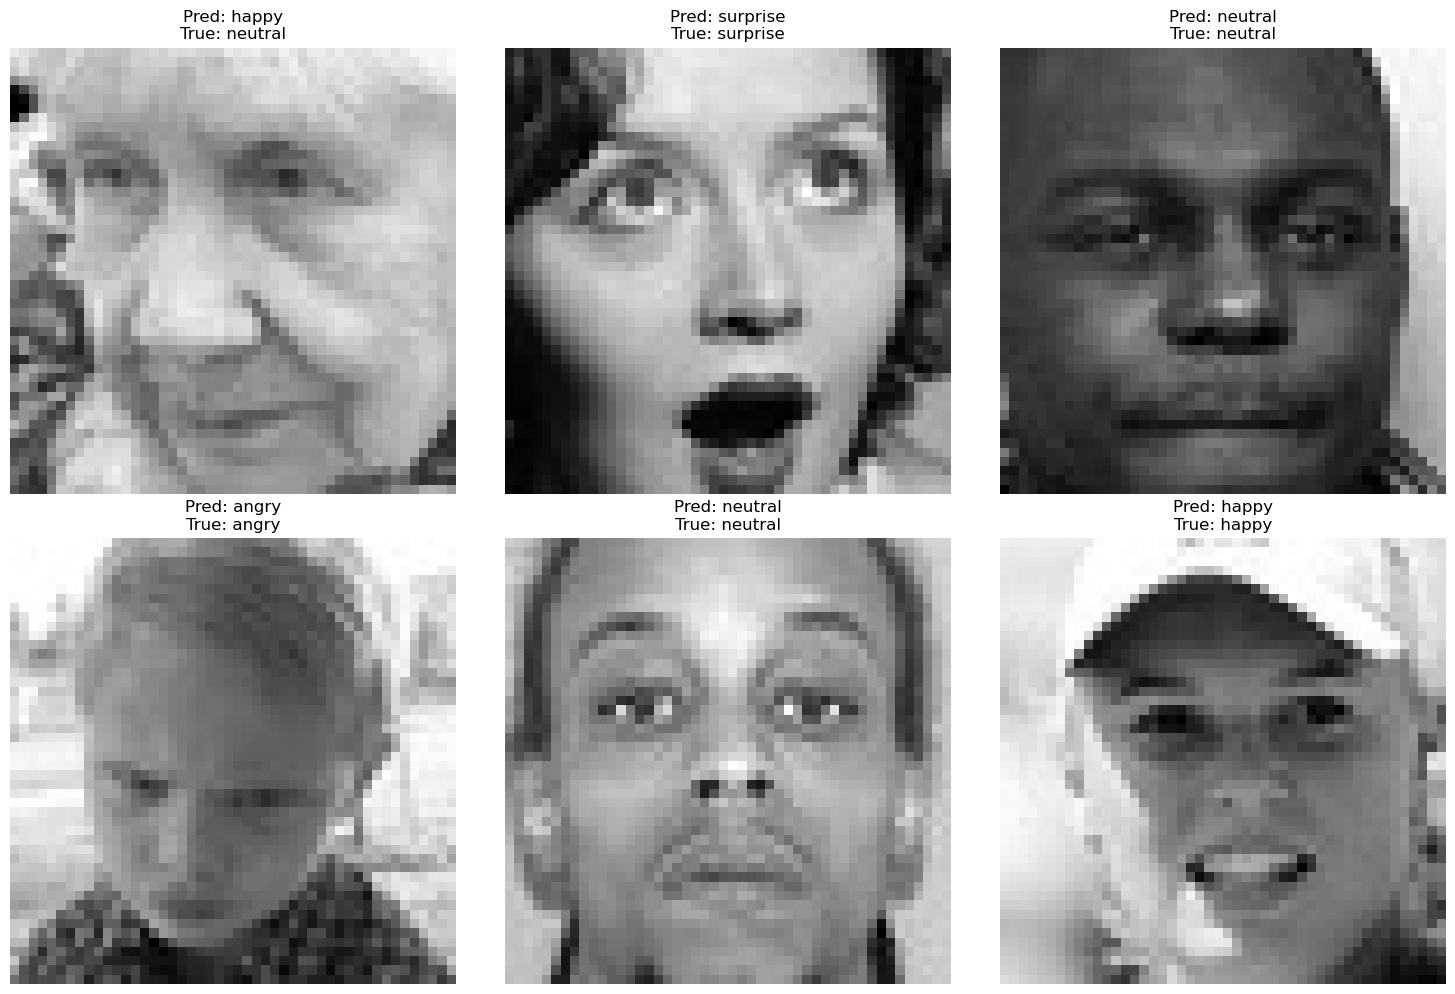

In [6]:
sample_images, sample_labels = next(test_generator)
predictions = baseline_model.predict(sample_images)
plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    pred_label = class_names[np.argmax(predictions[i])]
    true_label = class_names[np.argmax(sample_labels[i])]
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# 3.1.3 Design, Train, and Evaluate Deeper Architecture with Regularization


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 128)      512       
 hNormalization)                                                 
                                                      

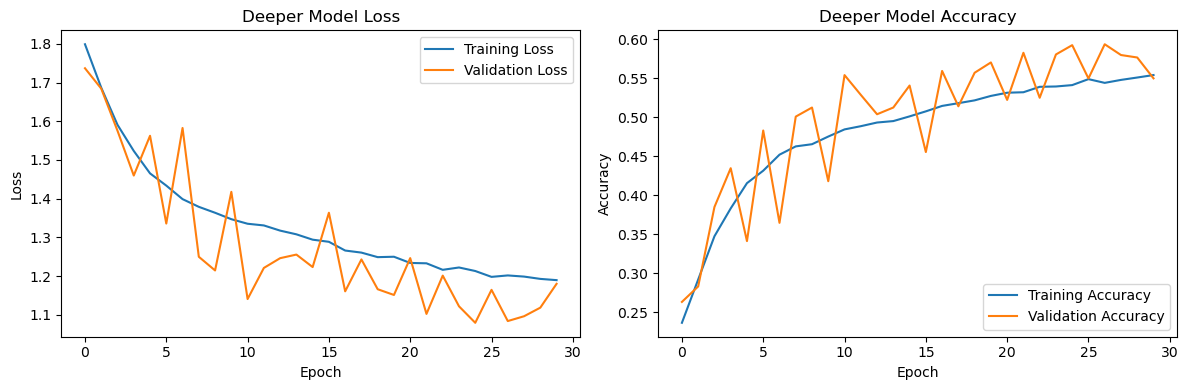

In [7]:

# Deeper CNN Model with Regularization
deeper_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

deeper_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

deeper_model.summary()

# Train deeper model
start_time = time.time()
history_deeper = deeper_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    verbose=1
)
training_time_deeper = time.time() - start_time

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_deeper.history['loss'], label='Training Loss')
plt.plot(history_deeper.history['val_loss'], label='Validation Loss')
plt.title('Deeper Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_deeper.history['accuracy'], label='Training Accuracy')
plt.plot(history_deeper.history['val_accuracy'], label='Validation Accuracy')
plt.title('Deeper Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

**Evaluate deeper model**


57/57 [==============================] - 3s 50ms/step - loss: 1.2817 - accuracy: 0.5150
Deeper Model Test Accuracy: 0.5150
57/57 [==============================] - 3s 51ms/step

Classification Report - Deeper Model:
              precision    recall  f1-score   support

       happy       0.17      0.19      0.18       300
         sad       0.17      0.32      0.22       300
       angry       0.15      0.20      0.17       300
    surprise       0.16      0.08      0.11       300
        fear       0.15      0.04      0.06       300
     neutral       0.16      0.14      0.15       300

    accuracy                           0.16      1800
   macro avg       0.16      0.16      0.15      1800
weighted avg       0.16      0.16      0.15      1800



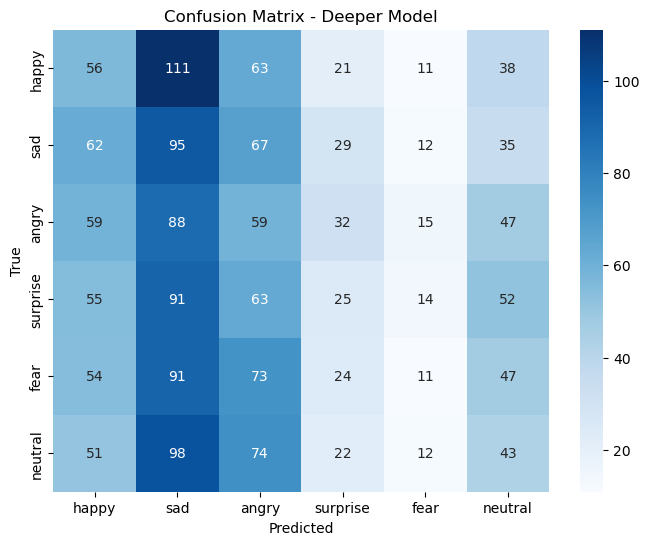

In [8]:
test_loss_deeper, test_accuracy_deeper = deeper_model.evaluate(test_generator)
print(f"Deeper Model Test Accuracy: {test_accuracy_deeper:.4f}")

# Generate predictions
test_generator.reset()
y_pred_deeper = deeper_model.predict(test_generator)
y_pred_classes_deeper = np.argmax(y_pred_deeper, axis=1)

# Classification report
print("\nClassification Report - Deeper Model:")
print(classification_report(y_true, y_pred_classes_deeper, target_names=class_names))

# Confusion matrix
cm_deeper = confusion_matrix(y_true, y_pred_classes_deeper)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_deeper, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Deeper Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 3.1.4 Experimentation and Comparative Analysis

Epoch 1/30
830/830 [==============================] - 193s 231ms/step - loss: 1.7733 - accuracy: 0.2498 - val_loss: 1.7477 - val_accuracy: 0.2624
Epoch 2/30
830/830 [==============================] - 190s 229ms/step - loss: 1.7436 - accuracy: 0.2580 - val_loss: 1.7307 - val_accuracy: 0.2644
Epoch 3/30
830/830 [==============================] - 193s 232ms/step - loss: 1.7335 - accuracy: 0.2617 - val_loss: 1.6831 - val_accuracy: 0.2991
Epoch 4/30
830/830 [==============================] - 191s 230ms/step - loss: 1.7061 - accuracy: 0.2789 - val_loss: 1.9237 - val_accuracy: 0.2012
Epoch 5/30
830/830 [==============================] - 191s 231ms/step - loss: 1.6697 - accuracy: 0.2978 - val_loss: 1.6863 - val_accuracy: 0.3067
Epoch 6/30
830/830 [==============================] - 194s 233ms/step - loss: 1.6184 - accuracy: 0.3280 - val_loss: 1.5387 - val_accuracy: 0.3688
Epoch 7/30
830/830 [==============================] - 191s 230ms/step - loss: 1.5784 - accuracy: 0.3512 - val_loss: 1.5888 -

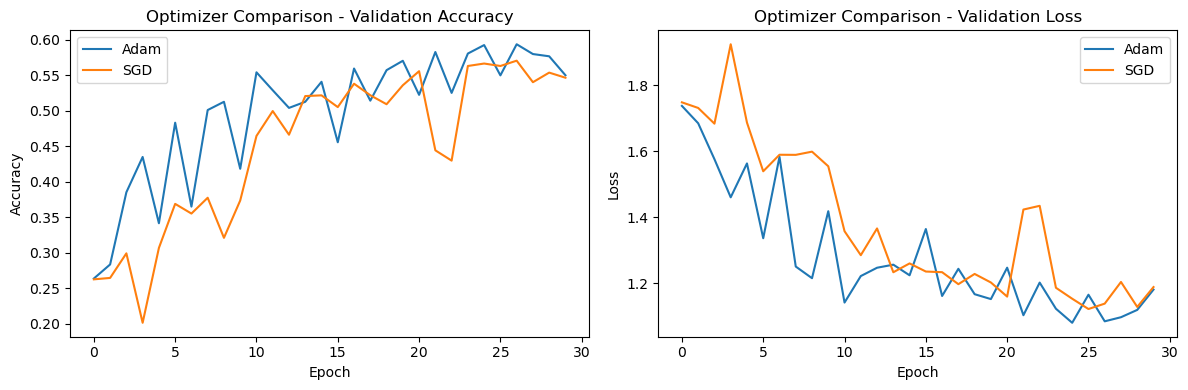

Deeper Model Training Time (Adam): 5802.56 seconds
Deeper Model Training Time (SGD): 5890.23 seconds


In [9]:
# Optimizer Analysis: SGD vs Adam
deeper_model_sgd = tf.keras.models.clone_model(deeper_model)
deeper_model_sgd.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

start_time_sgd = time.time()
history_sgd = deeper_model_sgd.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    verbose=1
)
training_time_sgd = time.time() - start_time_sgd

# Plot optimizer comparison
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_deeper.history['val_accuracy'], label='Adam')
plt.plot(history_sgd.history['val_accuracy'], label='SGD')
plt.title('Optimizer Comparison - Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_deeper.history['val_loss'], label='Adam')
plt.plot(history_sgd.history['val_loss'], label='SGD')
plt.title('Optimizer Comparison - Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Compare computational efficiency
print(f"Deeper Model Training Time (Adam): {training_time_deeper:.2f} seconds")
print(f"Deeper Model Training Time (SGD): {training_time_sgd:.2f} seconds")

# Part B: Fine-Tuning a Pre-Trained Model

In [ ]:
from tensorflow.keras.applications import VGG16


# Create data generators for RGB input (for VGG16)
train_datagen_rgb = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen_rgb = ImageDataGenerator(
    rescale=1./255
)

test_datagen_rgb = ImageDataGenerator(
    rescale=1./255
)

# Load datasets as RGB directly
train_generator_rgb = train_datagen_rgb.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='rgb',  
    batch_size=32,
    class_mode='categorical',
    classes=['happy', 'sad', 'angry', 'surprise', 'fear', 'neutral']
)

val_generator_rgb = val_datagen_rgb.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    color_mode='rgb',  
    batch_size=32,
    class_mode='categorical',
    classes=['happy', 'sad', 'angry', 'surprise', 'fear', 'neutral']
)

test_generator_rgb = test_datagen_rgb.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode='rgb',  
    batch_size=32,
    class_mode='categorical',
    classes=['happy', 'sad', 'angry', 'surprise', 'fear', 'neutral']
)

# Load VGG16 pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

Found 26543 images belonging to 6 classes.
Found 6955 images belonging to 6 classes.
Found 1800 images belonging to 6 classes.


In [10]:
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create transfer learning model
transfer_model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

# Compile the model
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 1

In [11]:
# Train transfer learning model (feature extraction)
history_transfer = transfer_model.fit(
    train_generator_rgb,
    epochs=15,
    validation_data=val_generator_rgb,
    verbose=1
)

# Fine-tuning: Unfreeze the last 4 layers
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile with a smaller learning rate for fine-tuning
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training for fine-tuning
history_finetune = transfer_model.fit(
    train_generator_rgb,
    epochs=10,
    validation_data=val_generator_rgb,
    verbose=1
)


Epoch 1/15
830/830 [==============================] - 256s 308ms/step - loss: 1.7341 - accuracy: 0.2683 - val_loss: 1.6227 - val_accuracy: 0.3434
Epoch 2/15
830/830 [==============================] - 263s 317ms/step - loss: 1.6434 - accuracy: 0.3234 - val_loss: 1.5777 - val_accuracy: 0.3730
Epoch 3/15
830/830 [==============================] - 267s 322ms/step - loss: 1.6117 - accuracy: 0.3422 - val_loss: 1.5504 - val_accuracy: 0.3812
Epoch 4/15
830/830 [==============================] - 263s 317ms/step - loss: 1.5928 - accuracy: 0.3534 - val_loss: 1.5309 - val_accuracy: 0.3918
Epoch 5/15
830/830 [==============================] - 258s 311ms/step - loss: 1.5802 - accuracy: 0.3612 - val_loss: 1.5171 - val_accuracy: 0.3977
Epoch 6/15
830/830 [==============================] - 256s 308ms/step - loss: 1.5688 - accuracy: 0.3682 - val_loss: 1.5073 - val_accuracy: 0.4007
Epoch 7/15
830/830 [==============================] - 258s 311ms/step - loss: 1.5581 - accuracy: 0.3746 - val_loss: 1.4976 -

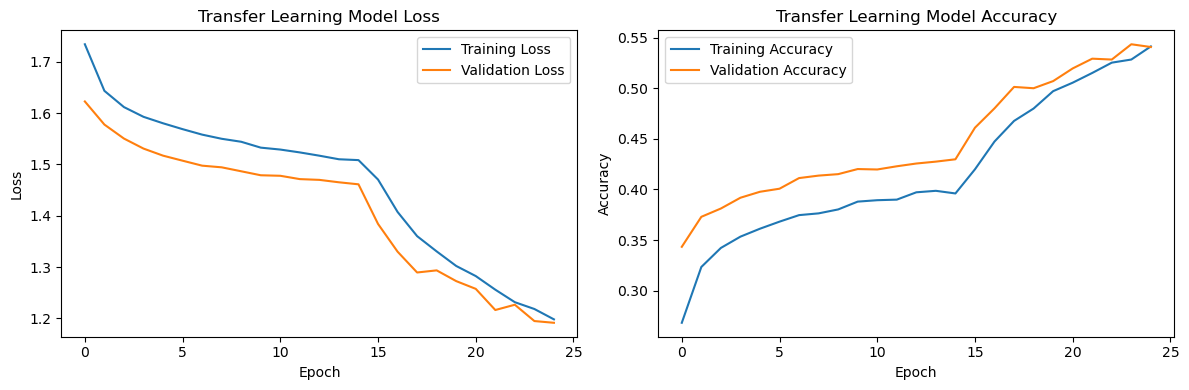

In [12]:
# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['loss'] + history_finetune.history['loss'], label='Training Loss')
plt.plot(history_transfer.history['val_loss'] + history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['accuracy'] + history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_transfer.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

In [13]:
# Evaluate transfer learning model
test_loss_transfer, test_accuracy_transfer = transfer_model.evaluate(test_generator_rgb)
print(f"Transfer Learning Model Test Accuracy: {test_accuracy_transfer:.4f}")

# Generate predictions
test_generator_rgb.reset()
y_pred_transfer = transfer_model.predict(test_generator_rgb)
y_pred_classes_transfer = np.argmax(y_pred_transfer, axis=1)
y_true = test_generator_rgb.classes

# Classification report
class_names = list(test_generator_rgb.class_indices.keys())
print("\nClassification Report - Transfer Learning Model:")
print(classification_report(y_true, y_pred_classes_transfer, target_names=class_names))


57/57 [==============================] - 31s 536ms/step - loss: 1.3110 - accuracy: 0.4878
Transfer Learning Model Test Accuracy: 0.4878
57/57 [==============================] - 16s 271ms/step

Classification Report - Transfer Learning Model:
              precision    recall  f1-score   support

       happy       0.16      0.24      0.19       300
         sad       0.17      0.12      0.14       300
       angry       0.13      0.11      0.12       300
    surprise       0.15      0.13      0.14       300
        fear       0.15      0.07      0.10       300
     neutral       0.14      0.22      0.17       300

    accuracy                           0.15      1800
   macro avg       0.15      0.15      0.14      1800
weighted avg       0.15      0.15      0.14      1800



Text(70.72222222222221, 0.5, 'True')

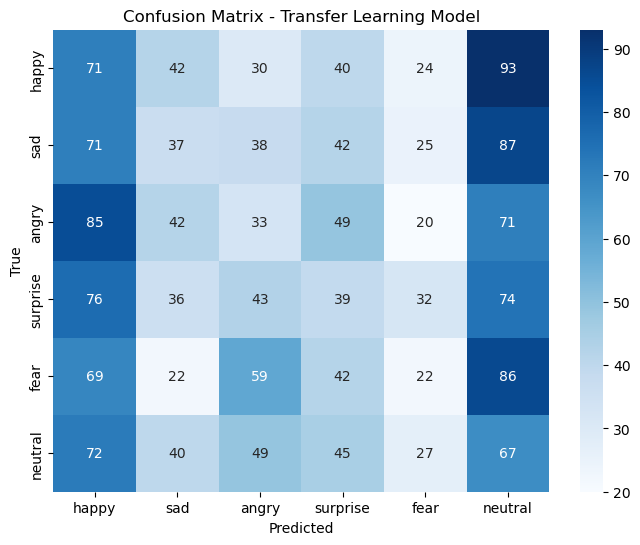

In [14]:
# Confusion matrix
cm_transfer = confusion_matrix(y_true, y_pred_classes_transfer)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Transfer Learning Model')
plt.xlabel('Predicted')
plt.ylabel('True')